In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !unrar x "/content/drive/MyDrive/SmartBin/data.rar" "/content/data/"

In [ ]:
# !unrar x "/content/drive/MyDrive/SmartBin/dataset2.rar" "/content/datasets/"

In [ ]:
import tensorflow as tf
import os
import cv2 as cv
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense

In [ ]:
IMG_SIZE = 224
CHANNELS = 3
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE
path = "/content/data"
data_dir = Path(path)


In [ ]:
CLASS_NAMES = os.listdir(path)
CLASS_NAMES

['paper', 'bottle', 'can']

In [ ]:
num_bottle_img = len(list(data_dir.glob('bottle/*')))
num_can_img = len(list(data_dir.glob('can/*')))
num_paper_img = len(list(data_dir.glob('paper/*')))
total_img = num_bottle_img + num_can_img + num_paper_img
print('Total Bottle Image: ', num_bottle_img)
print('Total Can Image: ', num_can_img)
print('Total Paper Image: ', num_paper_img)
print('Total Image: ', total_img)

Total Bottle Image:  1269
Total Can Image:  1198
Total Paper Image:  1110
Total Image:  3577


In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(total_img, reshuffle_each_iteration=False)

In [ ]:
for f in list_ds.take(5):
    print(f.numpy())

b'/content/data/can/image_20220604_104029.jpeg'
b'/content/data/can/image_20220614_155730.jpeg'
b'/content/data/bottle/image_20220615_170814.jpeg'
b'/content/data/paper/paper557.jpg'
b'/content/data/can/image_20220604_103946.jpeg'


In [ ]:
def get_data_partition(ds, train_size=0.9, valid_size=0.1):
  n_samples = len(ds)
  train_samples = int(train_size*n_samples)
  train_ds = ds.take(train_samples)

  val_samples = int(valid_size*n_samples)
  val_ds = ds.skip(train_samples).take(val_samples)

  # test_ds = ds.skip(train_samples).skip(val_samples)
  return train_ds, val_ds


In [ ]:
train_ds, val_ds = get_data_partition(list_ds)
print('Number of samples in train_ds: ', len(train_ds))
print('Number of samples in val_ds: ', len(val_ds))

Number of samples in train_ds:  3219
Number of samples in val_ds:  357


In [ ]:
def get_label(file_path):
  onehot=[0, 0, 0]
  file_split = tf.strings.split(file_path, os.path.sep)
  for i, label in enumerate(CLASS_NAMES):
    if label == file_split[-2]:
      onehot[i] = 1
  return tf.convert_to_tensor(onehot)

print(CLASS_NAMES)
for file in list_ds.take(5):
  print('File name: ', file.numpy().decode('utf-8'))
  print('Label: ', get_label(file).numpy())

['paper', 'bottle', 'can']
File name:  /content/data/can/image_20220604_104029.jpeg
Label:  [0 0 1]
File name:  /content/data/can/image_20220614_155730.jpeg
Label:  [0 0 1]
File name:  /content/data/bottle/image_20220615_170814.jpeg
Label:  [0 1 0]
File name:  /content/data/paper/paper557.jpg
Label:  [1 0 0]
File name:  /content/data/can/image_20220604_103946.jpeg
Label:  [0 0 1]


In [ ]:
from collections import Counter
label = []
for file in train_ds:
  label.append(np.argmax(get_label(file).numpy()))

Counter(label)

Counter({0: 997, 1: 1131, 2: 1091})

In [ ]:
def preprocessing(img_path):
  label = get_label(img_path)
  image = tf.io.read_file(img_path)
  image = tf.io.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  return image, label


In [ ]:
def data_preparation(ds, n_repeats=4):
  ds = ds.cache().shuffle(len(ds))
  ds = ds.map(preprocessing)
  ds = ds.repeat(n_repeats)
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(4)
  return ds

In [ ]:
train_ds = data_preparation(train_ds)
val_ds = data_preparation(val_ds)
# test_ds = data_preparation(test_ds)

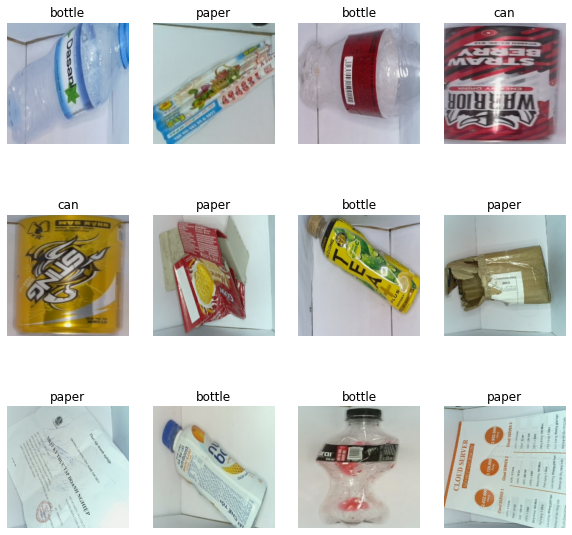

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow((image_batch[i] * 255).numpy().astype('uint8'))
    plt.axis('off')
    plt.title(CLASS_NAMES[np.argmax(label_batch[i])])

In [ ]:
trainNew = True
if trainNew ==True:
  base_model = tf.keras.applications.VGG16(input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS),
                                                include_top=False,
                                                weights='imagenet')

  base_model.trainable = False
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  flatten = Flatten()
  fc1 = Dense(20, activation='relu')
  fc2 = Dense(14, activation='relu')
  fc3 = Dense(7, activation='relu')
  prediction_layer = tf.keras.layers.Dense(3, activation='softmax')

  inputs = Input(shape=(224, 224, 3))
  x = base_model(inputs, training=False)
  x = global_average_layer(x)
  x = fc1(x)
  x = fc2(x)
  x = fc3(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = Model(inputs, outputs)
else:
  model = tf.keras.models.load_model("/content/drive/MyDrive/SmartBin/model_1")

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

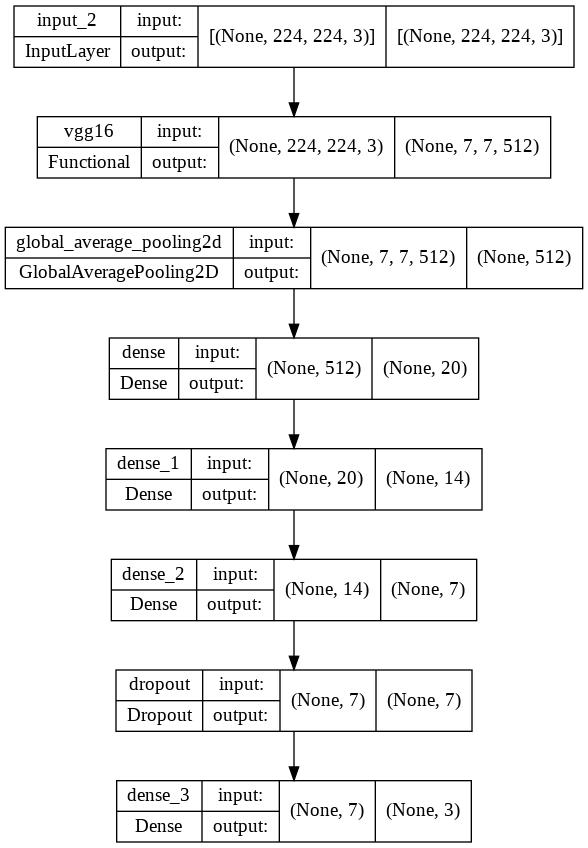

In [ ]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
EPOCHS = 25
with tf.device('/device:GPU:0'):
  history = model.fit(train_ds,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      verbose=1,
                      validation_data=val_ds)
model.save("/content/drive/MyDrive/SmartBin/model_final.h5")

Epoch 1/25
202/202 [==============================] - 58s 286ms/step - loss: 0.8433 - accuracy: 0.6323 - val_loss: 0.5411 - val_accuracy: 0.8852
Epoch 2/25
202/202 [==============================] - 56s 278ms/step - loss: 0.4922 - accuracy: 0.8194 - val_loss: 0.2827 - val_accuracy: 0.9328
Epoch 3/25
202/202 [==============================] - 57s 280ms/step - loss: 0.3293 - accuracy: 0.8901 - val_loss: 0.1764 - val_accuracy: 0.9692
Epoch 4/25
202/202 [==============================] - 56s 279ms/step - loss: 0.2640 - accuracy: 0.9091 - val_loss: 0.1322 - val_accuracy: 0.9692
Epoch 5/25
202/202 [==============================] - 56s 279ms/step - loss: 0.2260 - accuracy: 0.9230 - val_loss: 0.1191 - val_accuracy: 0.9664
Epoch 6/25
202/202 [==============================] - 57s 281ms/step - loss: 0.2044 - accuracy: 0.9277 - val_loss: 0.0811 - val_accuracy: 0.9720
Epoch 7/25
202/202 [==============================] - 56s 278ms/step - loss: 0.1800 - accuracy: 0.9345 - val_loss: 0.0699 - val_ac

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Accuracy')

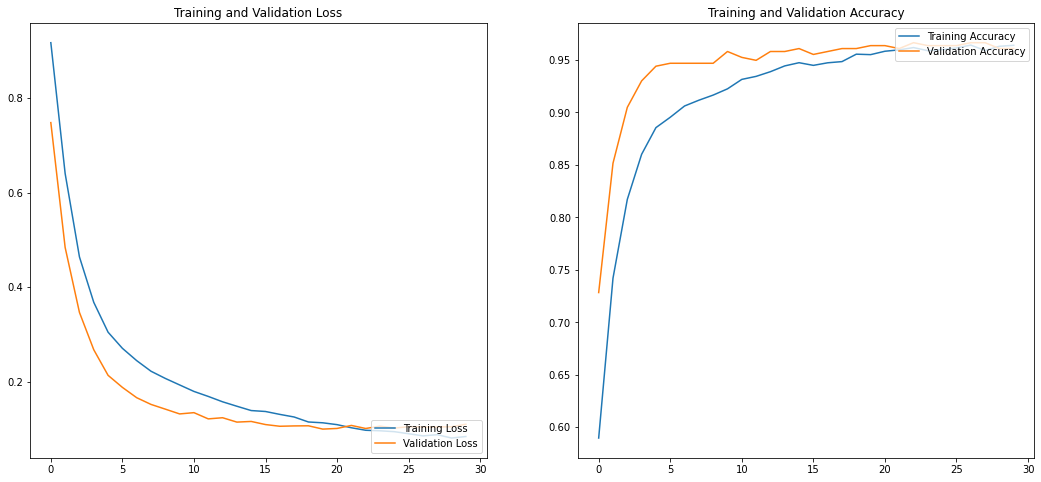

In [ ]:
n_epochs = range(EPOCHS)
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.plot(n_epochs, loss, label='Training Loss')
plt.plot(n_epochs, val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(n_epochs, accuracy, label='Training Accuracy')
plt.plot(n_epochs, val_accuracy, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

In [ ]:
model.evaluate(test_ds)

23/23 [==============================] - 7s 287ms/step - loss: 0.1245 - accuracy: 0.9638


[0.1244768425822258, 0.9637883305549622]